# Optimal Transport for Cross-lingual Word Alignments

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import ot
from tqdm import tqdm

from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN

from functions.utils import *

## Data extraction for coding cells

1. Alignements
2. Spanish sentences
3. French sentences
4. Pre-computed ***fastext*** vectors

In [4]:
# 1.
fr_es = open('data/raw/es-fr_1-100.wa', 'r')
alignements = transform_alignement_file(fr_es.readlines())

# 2.
es_100 = open('data/raw/1-100-final.es', 'r')
sentences_es = transform_sentence_file(es_100.readlines())

# 3.
fr_100 = open('data/raw/1-100-final.fr', 'r')
sentences_fr = transform_sentence_file(fr_100.readlines())

# 4.
es_vectors = np.load('data/processed/vector_es_100.npy',allow_pickle=True)
fr_vectors = np.load('data/processed/vector_fr_100.npy',allow_pickle=True)

alignements_tab = lines_to_tab(alignements)

## Introduction

Les problématiques autour de la notion de *Word Embedding*, c'est-à-dire la représentation de mots sous forme de vecteurs, sont devenues centrales en Traitement du Langage. Ce passage du monde lettré à un espace mathématique bien défini, sans omettre le sens de chaque mot, seul et au sein de son contexte, est un chemin parsemé d'embuches que les méthodes modernes doivent éviter.

### Espace d'embeddings

Les travaux de Mikolov et al. ont fait émerger des méthodes innovantes (Skip-gram, CBOW) de représentations vectorielles de mots, conditionées par leur contexte au sein d'un corpus donné. L'innovation apportée par ces travaux est la capacité de traduire dans les représentations vectorielles des relations syntaxiques,  sémantiques mais aussi idiomatiques entre les mots. En effet, le coeur de problème de *Word Embedding* est de construire cette capacité à associer des mots sémantiquement différents comme "Air" et "France" afin de comprendre leur association, ici "Air France", et de traduire dans la somme des vecteurs le sens recherché à l'association, ici celui d'une compagnie aérienne française.

### Transposition multilingue

Dans la continuité de ces méthodes, la construction d'un espace vectoriel d'*embeddings* saisissant les règles sémantiques, synthaxiques mais aussi linguistiques, a pris un tournant multilingue. En effet, une fois ces espaces construits les informations linguistiques, peuvent être mises à contribution dans les problèmes de tranduction où elles sont essentielles. Les travaux de Mikolov et al. de 2018 ont proposé une première méthode simple et efficace visant à trouver une matrice de traduction optimale. Etant donné un jeu de mots $\{x_i,y_i\}^n_{i=1}$ sous forme vectorielle avec $x_i \in \mathbf{R}^{d_1}$ et $y_i \in \mathbf{R}^{d_2}$, le but est de trouver une matrice de traduction telle que :
$\begin{equation*}
\tilde{W} = \underset{W}{\argmin} \sum_{i=1}^n \lVert Wx_i - y_i \rVert^2
\end{equation*}$

en utilisant une descente de gradient. Cette méthode très simple affiche des résultats remarquables mais met en lumière cette question de translation entre espaces de vecteurs et donc espaces d'\textit{embeddings}. Les travaux de Xing et al. \cite{xing-etal-2015-normalized} ainsi que ceux de Arteka et al. consolident les aspects mathématiques à la méthode proposée précédemment. Parmi ces précisions, ressortent la normalisation des vecteurs ainsi que le caractère orthogonal de la matrice de traduction. La normalisation permet de cofondre similarité cosinus et produit vectoriel, et apporte donc une certaine cohérence dans les distances utilisées dans les différentes étapes de l'aglorithme de Skip-gram. L'orthogonalité de la matrice de traduction, quant à elle, permet une traduction de qualité tout en simplifiant grandement l'optimisation de la matrice puisque dans ce cas, en notant $X=(x_1, ..., x_n)^T$ et $Y=(y_1, ..., y_n)^T$ nous avons :

$$
\underset{W \in \mathcal{O}_d}{\argmin} \lVert WX - Y \rVert^2 = \underset{W \in \mathcal{O}_d}{\argmax}\space Tr(XWY^T)
$$

qui se calcule simplement en utilisant le théorème spectral et par diagonalisation.


### Earth Mover's Distance

Cette problématique naissante de translation multilingue entre espaces de vecteurs a pris une nouvelle dimension avec les travaux de Zhang et al. En partant des espaces vectoriels donnés par les algorithmes de *Word Embedding*, ces travaux proposent une méthode d'alignement isomorphique des *embeddings* d'un espace de départ dans un espace d'arrivée. Cette notion d'alignement et non de traduction un-à-un est clé dans cette méthode puisqu'elle utilise une notion linguistique (comme Mikolov dans Skip-gram) celle des invariances sémantiques entre deux langues différentes. Il est démontré que les espaces d'*embedding* de deux langues différentes se ressemble dans leur construction et sont même invariants selons certains points. Au delà de cette nouvelle approche, ces travaux introduisent une nouvelle métrique dans cette problématique de traduction, la *Earth Mover's Distance* (*EMD*) définie, pour deux distributions de probabilités discrètes $\mathbf{P}_1 = \underset{i}{\sum} u_i\delta_i$ et $\mathbf{P}_2 = \underset{j}{\sum} v_j\delta_j$, comme suit :

$$\begin{equation*}
EMD(\mathbf{P}_1, \mathbf{P}_2) = \underset{T \in \mathcal{U}(u,v)}{\min} \sum_i \sum_j T_{ij} c(x_i,y_j)
\end{equation*}$$

avec $c(x_i,y_j)$ la distance entre les points $x_i$ et $y_j$ et $\mathcal{U}(u,v)$ est le polytope de transport défini comme :

\begin{equation*}
\{ T / T_{ij}\geq 0 , \underset{j}{\sum} T_{ij}=u_i, \underset{i}{\sum} T_{ij}=v_j, \forall i,j \}
\end{equation*}.

Intuitivement, cette mesure cherche à minimiser les coûts de déplacement de chaque "tas" de probabilité d'une distribution vers ceux de la seconde. Nous nous rapprochons donc du problème de Transport Optimal qui fait partie intégrante de notre travail et sera présenté plus loin.


L'introduction de cette nouvelle distance permet une définition plus fine du problème et permet d'obtenir une traduction plus robuste face aux règles linguistiques. En effet, le problème devient donc d'aligner les vocabulaires, vus comme des distributions de probabilités, tout en minimisant le cout de déplacement, défini comme la distance des vecteurs d'\textit{embedding} de chaque vocabulaire. Cet alignement est représenté par la matrice de translation $T$ qui joue un rôle similaire au rôle de la matrice de traduction $W$ introduite par Mikolov, tout en permettant une traduction plus nuancée notamment en permettant de faire des associations \textit{many-to-one}. Ce point est loin d'être négligeable puisqu'il est linguistiquement obligatoire de pouvoir réaliser ce type d'associations. La forme de la matrice de translation doit répondre à certaines caractéristiques, notamment concernant la sparsité dont nous discuterons plus loin.

Les travaux de Zhang et al. proposent deux méthodes pour déterminer cette matrice $T$ dont une s'appuyant sur les travaux de Arjovsky et al. qui introduit le Wassersrtein GAN. La distance de Wassterstein se définit comme suit :

\begin{equation*}
W(\mathbf{P}_1, \mathbf{P}_2) = \underset{\gamma \in \Gamma(\mathbf{P}_1,\mathbf{P}_2)}{\inf} \mathbf{}{E}_{(x,y)~\gamma}[c(x,y)]
\end{equation*}

où $\Gamma(\mathbf{P}_1,\mathbf{P}_2)$ correspond à l'ensemble des distributions $\gamma(x,y)$ de distributions marginales $\mathbf{P}_1$ et $\mathbf{P}_2$. De part sa définition, la *EMD* se rapproche de cette distance de Wassterstein dans le cas discret. Les travaux de Arjovsky et al. proposent une utilisation des propriétés mathématiques d'un *Generative Adversarial Network* ou GAN pour résoudre le problème de :

\begin{equation*}
\underset{G \in \mathbf{R}^{d_1xd_2}}{\argmin W(\mathbf{P}^{G(S)}, \mathbf{P}^T)}
\end{equation*}

où $S$ désigne l'espace de départ, $T$ l'espace d'arrivée et $G$ la matrice de translation entre espaces d' *embedding*. En utilisant la dualité Kantorovich-Rubinstein établie par Villani, Arjovsky et al. proposent une solution fondée sur l'alterance de ces deux programmes de minimisations :

\begin{equation*}
T^{(k)} = \underset{T \in \mathcal{U}(f^S,f^T)}{\argmin} \underset{s}{\sum}\underset{t}{\sum} T_{st} c(G^{(k)}w_s^S,w_t^T)
\end{equation*}
\begin{equation*}
G^{(k+1)} = \underset{G \in \mathcal{O}(d)}{\argmin} \underset{s}{\sum}\underset{t}{\sum} T_{st}^{(k)} c(Gw_s^S,w_t^T)
\end{equation*}

avec une initialisation $G^{(0)}$ et en travaillant sur les fréquences de mots dans le vocabulaire $f^S$ et $f^T$.

Ces deux derniers ouvrages constituent le fondement de nos expérimentations. Les premiers travaux sur Skip-gram et ses optimisations mathématiques nous ont introduits à l'optimisation mathématique des espaces vectoriels d'*embeddings* pour conserver les proporiétés linguistiques du langage. Les travaux suivants ont cherché à faire correspondre deux espaces vectoriels d'*embeddings* tout en conservant les propriétés linguistiques, invariantes d'un espace à l'autre.  La problématique est donc devenue la détermination d'une matrice de translation entre deux espaces vectoriels. Les dernières méthodes proposées ont fait émerger une nouvelle vision du problème fondée sur les distributions de probabilités et en introduisant de nouvelles distances. Ces approches nous ont fait nous intéresser aux conditions de sparsité de notre matrice de translation et au Transport Optimal comme moyen de mise en relation de différents *embeddings* .


Notre expérimentation s'est donc concentrée sur le Transport Optimal et son efficacité dans les problèmes de traduction. Afin de donner un cadre plus précis à nos recherches, nous nous somme concentrés sur un problème de traduction précis : celui du Word Alignment. Semblable aux problèmes précédents, il permet de se détacher des papiers étduiés et de visualiser plus facilement les observations que nous cherchions à faire sur la sparsité de la matrice de traduction.

## Word Alignment

L'alignement des mots est une tâche de traitement du langage naturel qui consiste à identifier les relations de traduction entre les mots d'un texte et d'un autre texte traduit. Cette opération donne un graph biparti entre les textes, où un arc existe entre deux mots si et seulement si ces mots sont des traductions l'un de l'autre. L'alignement des mots est une tâche importante pour la plupart des méthodes de traduction automatique statistique. Nous pouvons notament citer l'utilisation des alignements de mots pour générer des matrices d'attention (Liu et al) ou encore leur utilisation pour le décodage par Alkhouli et al.

![Alignements entre une phrase en anglais et en français](assets/Word_alignment.png)

Comme nous voyons sur la figure, le problème d'alignement est très compliqué. En effet, tous les mots n'ont pas de traduction dans la seconde phrase, un mot peut être traduit en plusieurs mots et il arrive même que plusieurs mots soient traduit en un seul mot. Historiquement, déterminer les alignements de mots se faisaient avec des méthodes statistiques (chaînes de Markov cachées par Vogel et al) et en les déterminant parallèlement de le traduction. Néanmoins ces méthodes demandent énormément de données et leurs performances diminuent rapidement avec peu de données. Sabet et al. propose d'utiliser les embeddings des mots afin de calculer les alignement de mots. En effet, comme décrit en introduction, il est possible de créer des espaces de mots multilingue et ensuite de comparer les mots deux à deux en utilisant par example la distance cosinus. Ensuite, Sabet et al crééent des matrices de similarités qui seront utilisées par un algorithme appelé IterMax afin de faire les calculs des alignements. Cet algorithme affine l'idée de construction d'alignments suivant : 

- Soit $(A_{i,j})_{i,j}$ la matrice d'alignement où $A_{i,j} = 1$ si les mots $i$ et $j$ sont alignés et 0 sinon.
- $A_{i,j} = 1$ si $(i = \argmax_l S_{l,j}) \land (j = \argmax_l S_{l,i})$ avec $S$ la matrice de similarité.


Cette première méthode nous permet déjà de repérer des qualités importantes d'un bon algorithme de prédiction d'alignement. En effet, on s'attend déjà à ce que l'alignement soit une matrice très creuse car la traduction associe la majorité du temps un seul mot à un autre mots. De plus, pour des traductions du type Anglais/Français on s'attend aussi que la matrice se rapproche d'une certaine manière de la matrice identité (la diagonale dominante), mais il faut prendre cette heuristique avec des pincettes (exemple: inversion adjectif/nom entre l'anglais et le français).

Finalement, l'existence d'alignement optimaux pour de nombreuses phrases traduites nous permet de tester la précision et le rappel d'un certain algorithme d'alignement.

## Optimal Transport

Le problème du Transport Optimal, introduit précédemment avec la EMD, est un problème très intuitif. Historiquement formulé par Monge au XVIIIe siècle, il consiste à chercher le moyen le plus économique pour transporter des objets entre un ensemble de points de départ et de points d’arrivée. Mathématiquement parlant et d'une manière plus adaptée à notre problème, il consiste à minimiser la distance EMD entre deux distributions de probabilités $\mathbf{P}_u$ et $\mathbf{P}_v$ représentées par des vecteurs de probabilités $u$ et $v$ du simplexe $\Sigma_d=\{x\in\mathbf{R}_+^d, x^T\cdot\mathbf{1}_d=1\}$, espacées par une matrice de coût $M \in \mathbf{R}^{d \times d}_+$. Le problème se définit donc comme suit :

\begin{equation*}
\overset{~}{P} = \underset{P \in \mathcal{U}(u,v)}{\argmin} \langle P,M \rangle
\end{equation*}

où $\langle\cdot,\cdot\rangle$ est le produit de Frobenius. Lorsque la dimension (nous nous sommes contentés au cas où les deux vecteurs sont de même dimension par soucis de simplicité) augmente, ce problème devient long et couteux à résoudre correctement.

Avec une approche entropique, Cuturi \cite{cuturi2013sinkhorn} propose une méthode fondée sur l'aglorithme de Sinkhorn pour résoude efficacement le problème de Transport Optimal. En définissant l'entropie d'un vecteur $x \in \Sigma_d$ :

\begin{equation*}
h(x) = -\overset{d}{\underset{i=1}{\sum}} x_i\log(x_i)
\end{equation*}

le problème de Transport Optimal devient :

\begin{equation*}
\overset{~}{P_\lambda} = \underset{P \in \mathcal{U}(u,v)}{\argmin}  \langle P,M \rangle - \frac{1}{\lambda}h(P)
\end{equation*}

Ajouter un terme de régularisation entropique simplifie la résolution du problème pusique la solution $P_\lambda$ a finalement une forme très simple. En effet, d'après le théorème de Sinkhorn (1967), pour tout $\lambda \in \mathbf{R_+^*}$, la solution $P_\lambda \in \mathcal{U}(u,v)$ est unique et est de la forme : 

\begin{equation*}
P_\lambda = diag(x_1)Kdiag(x_2), K = e^{-\lambda M}
\end{equation*}


Les vecteurs positifs $x_1,x_2 \in \mathbf{R}_+^d$ sont uniques et calculés par doubles itérations successives $(x_1,x_2) \leftarrow (u/Kx_2,v/K^Tx_1)$. Puisque nous travillons avec des distributions de probabilités, il est raisonnable de poser, sans contrainte, $u > \mathbf{0}_d$. Sous cette hypothèse, la double itération peut être réduite à la simple itération suivante $x_1 \leftarrow 1/(\tilde{K}(v/K^Tx_1))$ avec la notation $\tilde{K}=diag(1/u)K$.


Ainsi, l'algorithme de Sinkhorn permet de résoudre efficacement le problème du Transport Optimal, en se débarrassant des contraintes de dimension et en donnant une forme simple à la solution grace à la régularisation entropique. La méthode de calcul, simple à implémenter, est illsutrée par l'\textbf{Algorithme 1}.

Particulièrement utile, cet algorithme introduit néanmoins un paramètre de régularisation qui nécessite une attention particulière. Influant sur la solution, il est nécessaire de mesure son impact sur la vitesse de convergence mais aussi sur la qualité de la solution. Puisqu'il résoud le problème par approximation, la solution peut s'éloigner de la solution optimale $P^\star$. Au delà de ces préoccupations classiques, il est important de vérifier la qualité de la matrice trouvée à travers sa sparsité. La régularisation ne doit pas proposer une solution $P^\lambda$ peu sparse là où $P^\star$ l'est. Les travaux de Blondel et al. \cite{blondel} démontrent que les régularisations entropiques peuvent être propices aux résultats sparses, ce qui est particulièrement positif dans notre sujet, mais sous certaines conditions à respecter.


Ainsi, nous débutons nos expérimentations dans l'optique d'appliquer le Transport Optimal au problème de Word Alignment. En utilisant l'aglorithme de Sinkhorn pour résoudre le problème de Transport Optimal, nous nous intéresserons à l'effet du paramètre de régularisation Lagrangien sur l'efficacité de l'algorithme mais aussi sur la qualité de la solution proposée. Une fois ce paramètre optimisé, nous nous intéresserons à une optimisation de la matrice de coùt $M$ qui joue un rôle crucial dans l'algorithme mais où très peu d'informations et de critères sont fixés. Nous explorerons donc les possibilités de construction de cette matrice en jouant notamment sur les distances utilisées et les procédés de régularisation des valeurs obtenues.

## Recherche

### Régularisation entropique

Dans l'article de Zi-Yi Dou et Graham Neubig la formulation de la solution théorique est basée sur le calcul d'un plan de transport optimal, ce plan de transport peut être vu comme un alignement de mots. Cependant, comme il a été dit dans la partie Transport Optimal, en pratique c'est le problème de transport optimal régularisé suivant (attention on a remplacé $\lambda$ par $\lambda^{-1}$) qui est résolu:

\begin{equation*}
\overset{~}{P_\lambda} = \underset{P \in U(u,v)}{\argmin}  \langle P,M \rangle - \lambda h(P)
\end{equation*}

Intuitivement, le terme de régularisation vise à rendre la matrice de transport moins creuse. Or, comme évoqué dans la partie Word Alignement, notre problématique d'alignement de mots requiert une matrice de transport le plus creuse possible.

Nous avons alors voulu quantifier à quel point le terme de régularisation impacte donc le caractère creux de la matrice. Pour ce faire, nous avons choisi d'utiliser la fonction entropie $h$ définie précédemment. En effet, une matrice d'alignement avec uniquement des $0$ et des $1$ a une entropie nulle, ce qui nous permet donc de quantifier correctement la sparsité de la matrice. Nous mesurons ci-contre l'entropie de la matrice de transport en fonction du paramètre de régularisation lagrangien $\lambda$:

In [5]:
def matrix_entropy(M: np.ndarray) -> float:
    """
    Return the entropy of the stochastic matrix M
    """
    EPSILON = 1e-10
    n,m = M.shape
    v = M.reshape((-1,1))
    return float(-np.log(v+EPSILON).T@v)/n

In [6]:
def generate_transport_matrix(r:np.ndarray, c:np.ndarray, cost_matrix: np.ndarray, lambda_reg:float, iterations=100) -> np.ndarray:
    """
    Use the sinkorn algorithm to calculate the transport matrix with lambda parameter lambda_reg
    """
    K = np.exp(-lambda_reg*cost_matrix)
    K_r = np.diag(1/r).dot(K)
    u = np.ones((r.shape[0],))
    for it in range(iterations):
        u = 1/(K_r.dot(c/(K.T.dot(u))))
    v = c/(K.T.dot(u))
    return np.diag(u).dot(K.dot(np.diag(v)))

ValueError: shapes (11,) and (2,2) not aligned: 11 (dim 0) != 2 (dim 0)

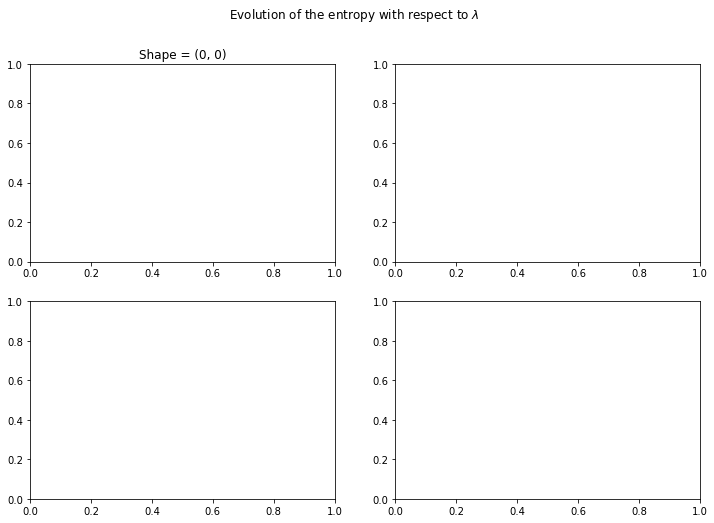

In [7]:
shapes = [(2,2), (10,2), (100,10), (100,100)]
grid_place = [(0,0), (0,1), (1,0), (1,1)]
lambdas = [1e-2, 5e-2, 1e-1, 5e-1, 1., 2., 4.]

r = np.asarray(es_vectors[np.random.randint(low=0, high=101)])
c = np.asarray(fr_vectors[np.random.randint(low=0, high=101)])
cost_matrix = 1-cosine_similarity(r,c)

fig, ax = plt.subplots(nrows=2, ncols= 2, figsize = (12,8))
fig.suptitle("Evolution of the entropy with respect to $\lambda$")

for place,shape in zip(grid_place,shapes):
    ax[place[0],place[1]].set_title(f"Shape = {place}")
    for i in range(6):
        cost_matrix = np.random.rand(shape[0],shape[1])
        entropy = [matrix_entropy(generate_transport_matrix(r,c,cost_matrix,lambda_reg)) for lambda_reg in lambdas]
        ax[place[0],place[1]].plot(lambdas, entropy, color = "gray")

plt.show()

De manière nettement visible, nous concluons qu'il est primordial de bien choisir le $\lambda$, c'est à dire proche de $0$, pour ne pas perdre le caractère creux recherché de la matrice de transport.

Néanmoins, s'il semble suffir de prendre $\lambda = 10^-9$ par exemple, nous remarquons que dans l'algorithme Sinkhorn \ref{alg:sinkhorn}, il est nécessaire de travailler avec des grandeurs de l'ordre de $e^{\lambda^{-1}}$.


### Matrice de coût

Le second axe de recherche sur lequel nous nous sommes focalisé est le rôle de la matrice de coût intervenant dans le problème de Transport Optimal. Cette matrice est la pierre angulaire du problème puisqu'elle aiguille la répartition de la distribution de départ sur celle d'arrivée.

Dans notre cas du  Word Alignment, la matrice de coût indique quels mots peuvent être facilement mis en relation de part leur similarité sémantique et linguistique. La difficulté réside donc dans la construction d'une matrice transmettant une information suffisante pour obtenir une matrice de traduction optimale. Malgré le rôle essentiel de cette matrice, peu voire aucun papier de recherche n'expose précisément les règles auxquelles elle doit répondre. Par exemple, certains parlent de matrice de distance où les coefficients sont à valeurs dans $[0,1]$, d'autres de matrice de coût donc borne fixée au préalable. Quelle forme donner à $M$ pour optimiser le résultat final? Quelles sont les règles auxquelles la matrice $M$ doit obéir pour résoudre le problème de Word Alignment avec le Transport Optimal?

Nous sommes partis des travaux de Dou et al. qui introduisent récemment le Transport Optimal sur la thématique du Word Alignment mais sans l'évaluer concrètement. Cette implémentation constitue donc notre base depuis laquelle nous menons nos expérimentations et améliorerons les performances.

In [8]:
## Algorithme transport optimal pour les Word Alignment

def computeAlignments(sentences_id, threshold, Lambda, 
regularization=False, epsilon_reg=None,
add_non_linearity=False, non_linear_transformation=None,
extractor=False, extraction_method=None):
    
    es_vector = np.asarray(es_vectors[sentences_id])
    fr_vector = np.asarray(fr_vectors[sentences_id])

    P_es = np.ones(es_vector.shape[0])*[1/es_vector.shape[0]]
    P_fr = np.ones(fr_vector.shape[0])*[1/fr_vector.shape[0]]

    cost = (1-cosine_similarity(es_vector,fr_vector))
    if regularization:
        cost *= epsilon_reg
    if add_non_linearity:
        cost = non_linear_transformation(cost)
    
    S = ot.sinkhorn(P_es, P_fr, cost, Lambda)
    if extractor:
        S = extraction_method(S)
        return np.where(S==-1, 1., 0.)
    else:
        scaler = MinMaxScaler()
        S = scaler.fit_transform(S)
        return np.where(S>threshold, 1., 0.)

Les performances de cette méthode ont donc été mesurées sur les $100$ phrases Français - Espagnol du jeu de données \textit{golden collection}. Les grandeurs relevées pour chaque phrase sont le \textit{rappel} R, la \textit{précision} P et le \textit{f-score} F, définies comme suit :

\begin{align*}
R&=\frac{\vert L_{pred} \cap L_{true} \vert}{\vert L_{true} \vert } \\
P&=\frac{\vert L_{pred} \cap L_{true} \vert}{\vert L_{pred} \vert } \\
F&=\frac{P\cdot R}{2(P+R)}
\end{align*}

où $L_{pred}$ et $L_{true}$ sont des listes de paires ($v_{w^{fr}_{i_1}}$,$v_{w^{es}_{j_1}}$) représentants des alignements de mots deux-à-deux. Ces trois grandeurs sont mesurées pour $\lambda = 0.002$ à la vue des conclusions précédentes. Cette valeur permet de maximiser les écarts de valeurs de la solution, notamment en donnant une matrice très sparse.

100%|██████████| 100/100 [00:02<00:00, 43.11it/s]


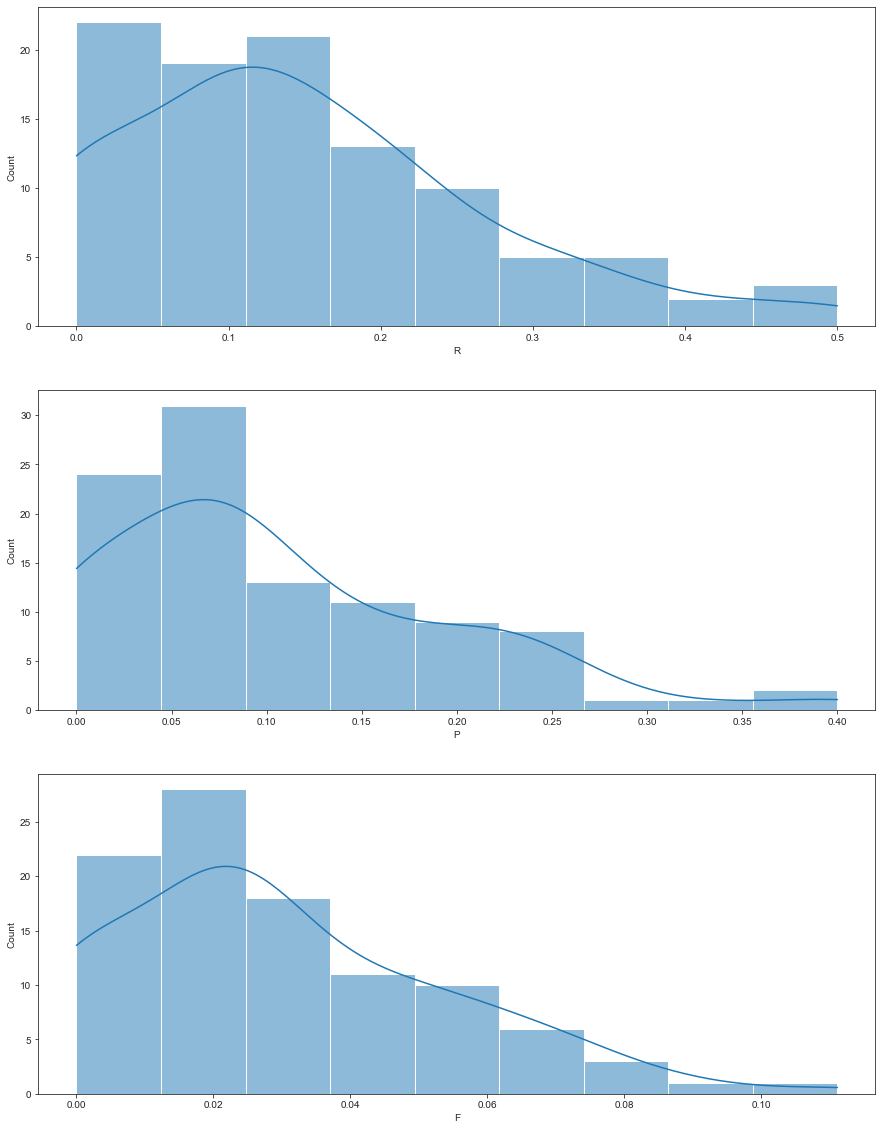

In [10]:
## Histogrammes et densités empiriques des grandeurs $R$,$P$ et $F$ de référence.            

def P(Lhyp, Lref):
    count = 0
    for elt in Lhyp:
        if elt in Lref:
            count+=1
    return count/len(Lhyp)

def R(Lhyp, Lref):
    count = 0
    for elt in Lref:
        if elt in Lhyp:
            count+=1
    return count/len(Lref)

def F(Lhyp, Lref):
    p = P(Lhyp, Lref)
    r = R(Lhyp, Lref)
    if p+r == 0:
        return 0
    return (p*r)/(2*(p+r))

def get_matrix(i):

    matrix = np.zeros((len(sentences_es[i]),len(sentences_fr[i])))
    for al in alignements_tab[i]:
        if al[2]=='S':
            matrix[al[0]-1][al[1]-1]=1
        else:
            matrix[al[0]-1][al[1]-1]=0.5
    return matrix

def analyse(n_sentence):
    c = 0
    ids = []
    r_list = []
    p_list = []
    f_list = []
    for sentence_id in tqdm(range(n_sentence)):

        A = computeAlignments(sentence_id,0.5,0.002)
        r_list = r_list + [R(extract_al(A), extract_al(get_matrix(sentence_id)))]
        p_list = p_list + [P(extract_al(A), extract_al(get_matrix(sentence_id)))]
        f = F(extract_al(A), extract_al(get_matrix(sentence_id)))
        f_list = f_list + [f]
        ids = ids + [sentence_id]
    dict = {"sentence":ids,"R":r_list,"P":p_list,"F":f_list}
    df = pd.DataFrame(dict)
    sns.set_style('ticks')
    fig, ax = plt.subplots(3,1,figsize=(15,20))
    sns.histplot(data=df, x="R", kde=True, ax=ax[0])
    sns.histplot(data=df, x="P", kde=True, ax=ax[1])
    sns.histplot(data=df, x="F", kde=True, ax=ax[2])

analyse(100)

Une fois ce modèle de référence déterminé et mesuré, certaines expérimentations peuvent être entreprises à partir de ce modèle. La première fait le lien entre nos études sur le paramètre de régularisation de l'algorithme de Sinkhorn. Les travaux de Cuturi (plus précisément son site internethttp://marcocuturi.net/SI.html) exposent des contraintes supplémentaires que devrait vérifier la matrice $M$. Ces critères flous, "il faut que $\lambda \max_{i,j}M_{ij} \leq 200$" nous ont aiguillé vers un premier travail sur la régularisation de la matrice de coût. Nous avons donc exploré quelles valeurs de $\epsilon_reg$ optimisait les résultats (donc les grandeurs $R$,$P$ et $F1$) en utilisant $M\times \epsilon_reg$ dans notre algorithme de Sinkhorn

#### Densités estimées des valeurs de $R$,$P$,$F1$ en fonction du paramètre $\epsilon_reg$ pour $\lambda = 0.002$


100%|██████████| 100/100 [00:02<00:00, 40.87it/s]


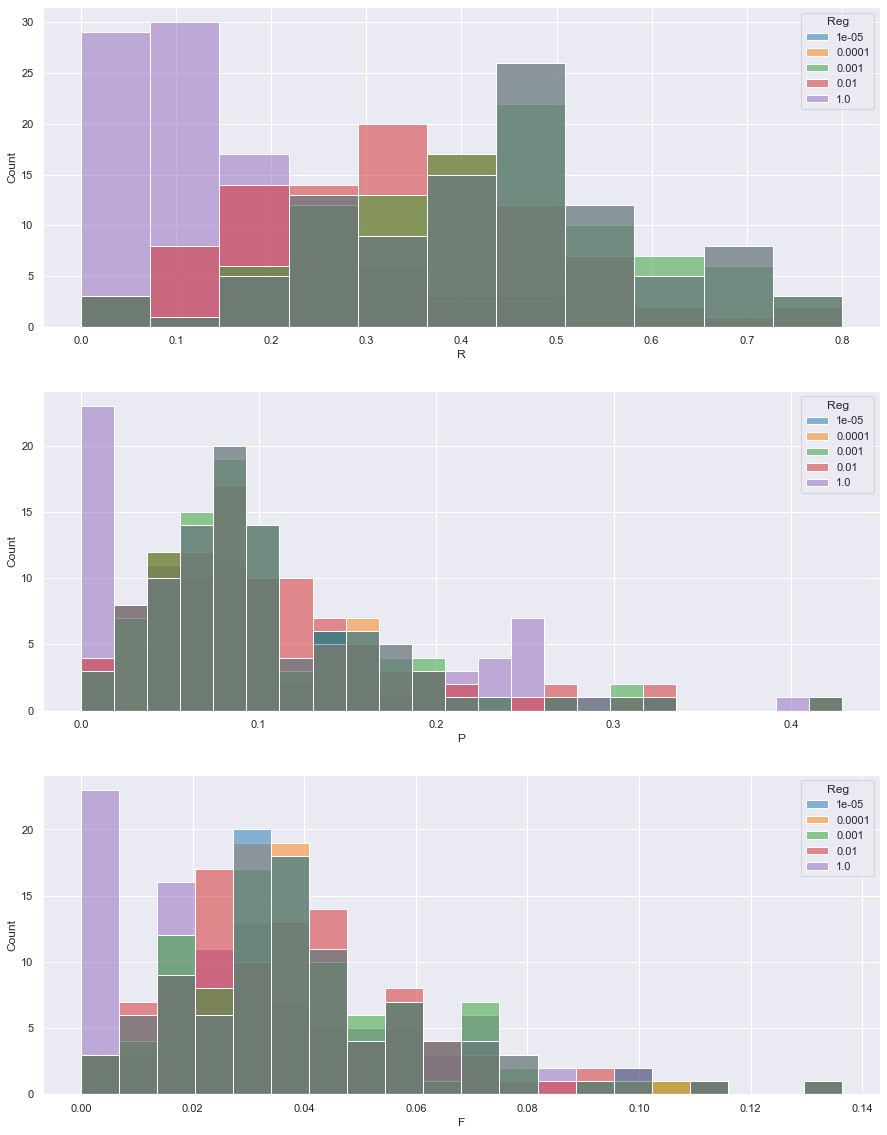

In [12]:
def analyse_reg(n_sentence, reg_values):
    ids = []
    regs = []
    r_list = []
    p_list = []
    f_list = []
    for reg in reg_values:
        for sentence_id in tqdm(range(n_sentence)):
            A = computeAlignments(
                sentence_id,0.6,0.002,
                regularization=True,
                epsilon_reg=reg
            )
            r_list = r_list + [R(extract_al(A), extract_al(get_matrix(sentence_id)))]
            p_list = p_list + [P(extract_al(A), extract_al(get_matrix(sentence_id)))]
            f = F(extract_al(A), extract_al(get_matrix(sentence_id)))
            f_list = f_list + [f]
            ids = ids + [sentence_id]
            regs = regs + [reg]
    dict = {"sentence":ids,"Reg":regs,"R":r_list,"P":p_list,"F":f_list}
    df = pd.DataFrame(dict)
    
    sns.set_theme()
    fig, ax = plt.subplots(3,1,figsize=(15,20))
    sns.histplot(data=df, x="R", hue="Reg", palette='tab10', ax=ax[0])
    sns.histplot(data=df, x="P", hue="Reg", palette='tab10', ax=ax[1])
    sns.histplot(data=df, x="F", hue="Reg", palette='tab10', ax=ax[2])

analyse_reg(100,[0.00001,0.0001,0.001,0.01,1])

Le choix d'un paramètre $reg$ très proche de $0$ permet à l'algorithme de Sinkhorn de produire, pour un $\lambda$ donné, des résultats alignements de meilleure qualité. Néanmoins, il reste possible que son rôle ne soit simplement que de favoriser la sparsité de la matrice finale et d'augmenter le nombre d'alignements, ce qui reste encore à être étudié. L'amélioration du F-score est quand même un indice positif de l'effet de ce paramètre puisque pour de mêmes conditions initiales, le nombre de $f-score$ égaux ou très proches de $0$ diminue drastiquement.

Ces premières expérimentations ouvrent la porte à un travail sur les mesures qui déterminent la matrice de coût. Si le paramètre $\epsilon_reg$ tend à augmenter le nombre d'alignements, une matrice de coût plus optimale pourrait finalement concilier résultats cohérents et régularisation de la matrice pour l'algorithme de Sinkhorn.

Dans la méthode de référence, la matrice de coût est donc définie comme la cosine distance, définie par $1-CosineSimilarity(\cdot)$. Plusieurs travaux connexes écrivent utiliser simplement $CosineSimilarity$, c'est-à-dire le cosinus. 

Néanmoins, cette fonction renvoie des valeurs dans $[-1,1]$, où $1$ signifie que les vecteurs sont similaires et $-1$ qu'ils sont opposés, en sens comme en forme, ceci dépendant du modèle d'embedding utilisé pour construire les vecteurs. Logiquement, pour que l'algorithme du Transport Optimal mette en relation deux vecteurs $v_{w^{fr}_i}$,$v_{w^{es}_j}$ et similaires, il est nécessaire que $M_{ij}$ soit proche de $0$. Sans preuve mathématique, cela se comprend intuitivement en revenant à la formulation initiale du problème de Transport Optimal qui est de déplacer le plus économiquement possible des "tas" de probabilités. Si deux "tas" sont "proches" ils seront donc facilement mis en relation pour limiter le coût total. Il faut donc que notre matrice de coût attribue des poids faibles pour les vecteurs à aligner.

La qualité d'une métrique sera donc sa capacité à évaluer proche de $0$ des vecteurs à aligner et d'attribuer une "grande valeur" à deux vecteurs éloignés sémantiquement et linguistiquement. Cette notion de "grande valeur" fait l'objet d'un premier questionnement. Est-il préférable d'utiliser une distance à valeurs dans $[0,1]$ ou une fonction de coût dans $[0,+\infty[$ dans la plupart des cas bornée. Nous prennons la décision de nous rapprocher de la formulation historique du problème du Transport Optimal et de ne pas nous contenter à des distances dans la boule unité. En effet, aucune contrainte ne semble nous en empêcher et nous trouvons intéressant de travailler, en plus des fonctions de coût, sur la répartition statistique (variance, quartiles,...) optimale des coûts pour orienter le système vers la bonne décision.

Nous cherchons donc une méthode non-linéaire de transformation de la distance initiale $(u,v) \rightarrow 1-CosineSimilarity(u,v)$ afin de détacher vers $0$ les vecteurs similaires, s'il en existe, tout en gardant un "ventre mou" compact et loin de l'origine. Ainsi, dans le cas où un vecteur est proche de tous les autres comme c'est le cas de mots clés, commme "le", "du" ou "un", cette méthode permet de détacher les plus pertinents tout en gardant la compacité de l'ensemble des autres coûts calculés. Nous proposons ici deux méthodes nommées $DiscExp$ et $DiscSquare$, définies pour $x \in X$ ensemble d'éléments de $\mathbf{R}$, telles que avec $\alpha = \mu(X)-IRQ(X)$

![](assets/DiscEQ.png)

In [13]:
def disc_square(S):
   
    exp_S = np.zeros_like(S)
    for i in range(S.shape[0]):
        Q1 = np.percentile(S[i], 25)
        IQR = stats.iqr(S[i])
        for j in range(S.shape[1]):
            if S[i][j]<np.mean(S)-IQR:
                exp_S[i][j]=(S[i][j])**4/(np.mean(S)-IQR)**3
            else:
                exp_S[i][j]=S[i][j]
    return exp_S

def disc_exp(S):
    exp_S = np.zeros_like(S)
    for i in range(S.shape[0]):
        Q1 = np.percentile(S[i], 25)
        IQR = stats.iqr(S[i])
        coef = (np.mean(S)-IQR)/(np.exp(np.mean(S)-IQR)-1)
        for j in range(S.shape[1]):
            if S[i][j]<np.mean(S)-IQR:
                exp_S[i][j]=(np.exp(S[i][j])-1)*coef
            else:
                exp_S[i][j]=S[i][j]
    return exp_S

Ces fonctions étant dépendantes de la variance des données, elle s'adaptent sans rigidité à chaque échantillon. Elles jouent un rôle d'étirement des valeurs aux extrémités et de compression à l'intérieur, leur effet étant illustré en comparaison avec la méthode de référence.

#### Illustration des effets des deux fonctions sur une distribution


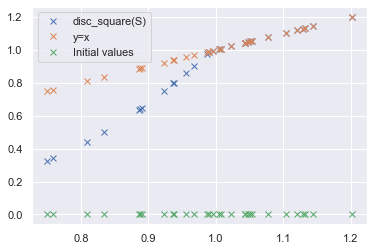

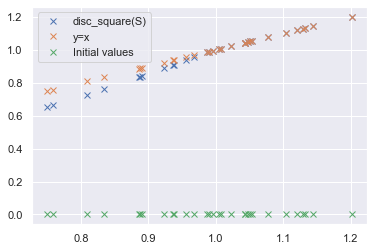

In [14]:
S = np.random.normal(1,0.1,30)
S = S.reshape(-1,1)

plt.plot(S,disc_square(S),'x',label='disc_square(S)')
plt.plot(S,S,'x',label='y=x')
plt.plot(S,np.zeros(S.shape[0]).reshape(-1,1),'x',label='Initial values')
plt.legend()
plt.show()

plt.plot(S,disc_exp(S),'x',label='disc_square(S)')
plt.plot(S,S,'x',label='y=x')
plt.plot(S,np.zeros(S.shape[0]).reshape(-1,1),'x',label='Initial values')
plt.legend()
plt.show()

L'intégration de ces métriques dans l'algorithme de Sninkhorn ne permet pas de tirer de réelles conclusions quant à l'efficacité de ce travail sur les distances. Comme illustré, les résultats des grandeurs d'évaluations diffèrent peu de la méthode de référence.

100%|██████████| 100/100 [00:00<00:00, 140.79it/s]


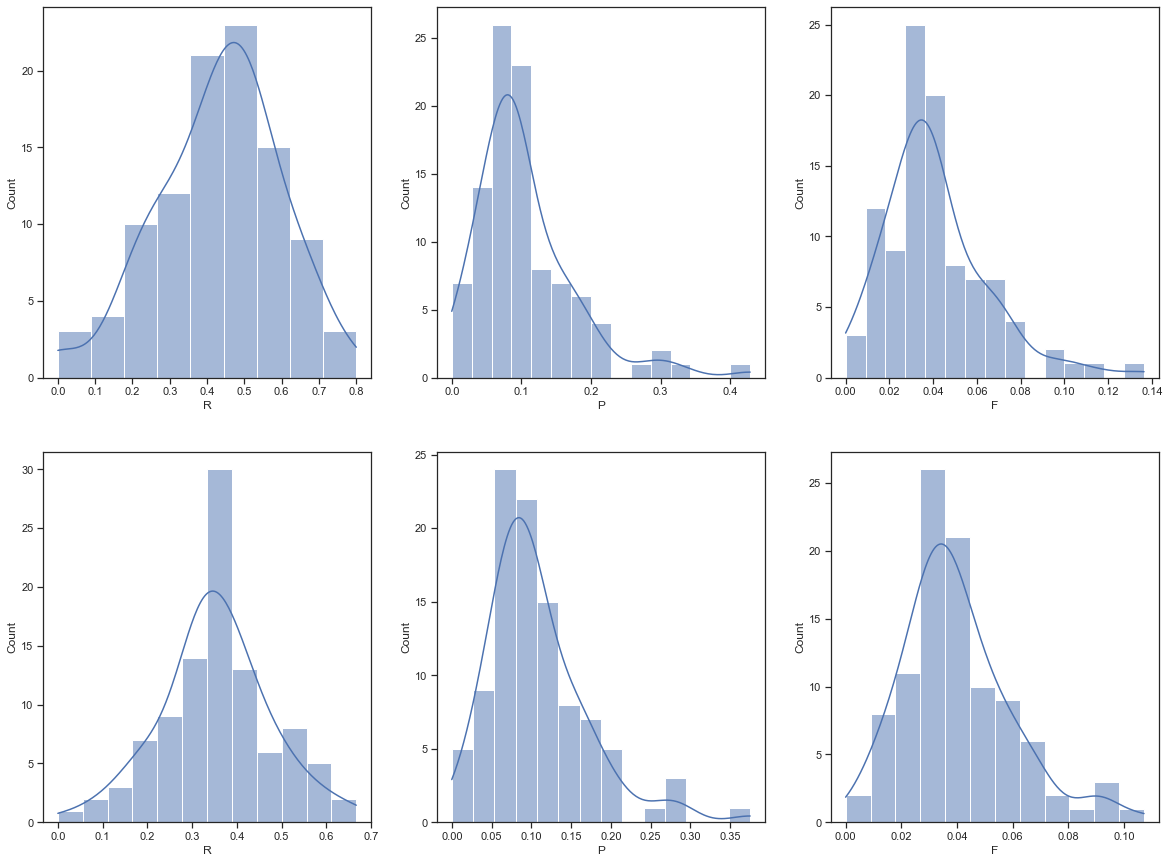

In [16]:
## Evaluation des performances $\discexp$ (en haut) et $\discsq$ (en bas) pour $\lambda=0.002$ et $reg=0.0001$.

def analyse_dist(n_sentence):

    ids = []
    r_list = []
    p_list = []
    f_list = []
    for sentence_id in tqdm(range(n_sentence)):
        A = computeAlignments(
            sentence_id,0.6,0.002,
            regularization=True,
            epsilon_reg=0.0001,
            add_non_linearity=True,
            non_linear_transformation=disc_exp
        )
        r_list = r_list + [R(extract_al(A), extract_al(get_matrix(sentence_id)))]
        p_list = p_list + [P(extract_al(A), extract_al(get_matrix(sentence_id)))]
        f = F(extract_al(A), extract_al(get_matrix(sentence_id)))
        f_list = f_list + [f]
        ids = ids + [sentence_id]
    dict = {"sentence":ids,"R":r_list,"P":p_list,"F":f_list}
    df = pd.DataFrame(dict)
    sns.set_style('ticks')
    fig, ax = plt.subplots(2,3,figsize=(20,15))
    sns.histplot(data=df, x="R", kde=True, ax=ax[0,0])
    sns.histplot(data=df, x="P", kde=True, ax=ax[0,1])
    sns.histplot(data=df, x="F", kde=True, ax=ax[0,2])

    ids = []
    r_list = []
    p_list = []
    f_list = []
    for sentence_id in tqdm(range(n_sentence)):
        A = computeAlignments(
            sentence_id,0.6,0.002,
            regularization=True,
            epsilon_reg=0.0001,
            add_non_linearity=True,
            non_linear_transformation=disc_square
        )
        r_list = r_list + [R(extract_al(A), extract_al(get_matrix(sentence_id)))]
        p_list = p_list + [P(extract_al(A), extract_al(get_matrix(sentence_id)))]
        f = F(extract_al(A), extract_al(get_matrix(sentence_id)))
        f_list = f_list + [f]
        ids = ids + [sentence_id]
    dict = {"sentence":ids,"R":r_list,"P":p_list,"F":f_list}
    df = pd.DataFrame(dict)
    sns.histplot(data=df, x="R", kde=True, ax=ax[1,0])
    sns.histplot(data=df, x="P", kde=True, ax=ax[1,1])
    sns.histplot(data=df, x="F", kde=True, ax=ax[1,2])

analyse(100)

Au delà du travail et de la réflexion sur la construction de la matrice de coût, une réflexion sur la méthode choisie pour extraire les alignements finaux est également intéressante. La méthode de référence propose comme de nombreuses autres papiers, une régulrisation $MnMx(\cdot)$ suivie d'un thresholding pour extraire les connections dépassant un certain seuil défini et fixé en amont. La régularisation $MnMx(\cdot)$ est discutable puisqu'elle oblige à faire au moins une association par mot. Pourtant, aucune règle linguistique ne l'indique et il doit pouvoir être possible qu'un mot soit aligné avec aucun autre. Toutes les langues ont leur particularités qui ne sont pas transposables dans les autres et cela doit pouvoir être pris en compte. De plus, la méthode de thresholding est peu flexible et pourrait être repensée plus finement.


Nous proposons une solution fondée sur la détection d'anomalies dans un jeu de données en utilisant l'algorithme de clustering DBScan de la librairie Scikit-learn. Cet algorithme va déterminer des clusters de voisins, faisant émerger des points dits d'intérieur et des points d'extérieur. Ces derniers sont donc les fameux outliers, ceux qui se détachent du reste des points vis-à-vis de la distribution de l'ensemble. Ainsi, nous obtenons une méthode moins rigide et prêtant plus d'attention à la répartition des données en permettant, entre autres, qu'un mot ne soit aligné avec aucun autre.


In [17]:
## Définition de la méthode de clustering

def transform_DBS(S:np.ndarray):
    A = np.zeros_like(S)
    for i in range(S.shape[0]):
        scan = DBSCAN(eps=np.std(S[i])/4,min_samples=max(3,len(S[i])//4)).fit_predict(S[i].reshape(-1,1))
        A[i] = scan
    return A

100%|██████████| 100/100 [00:00<00:00, 124.85it/s]


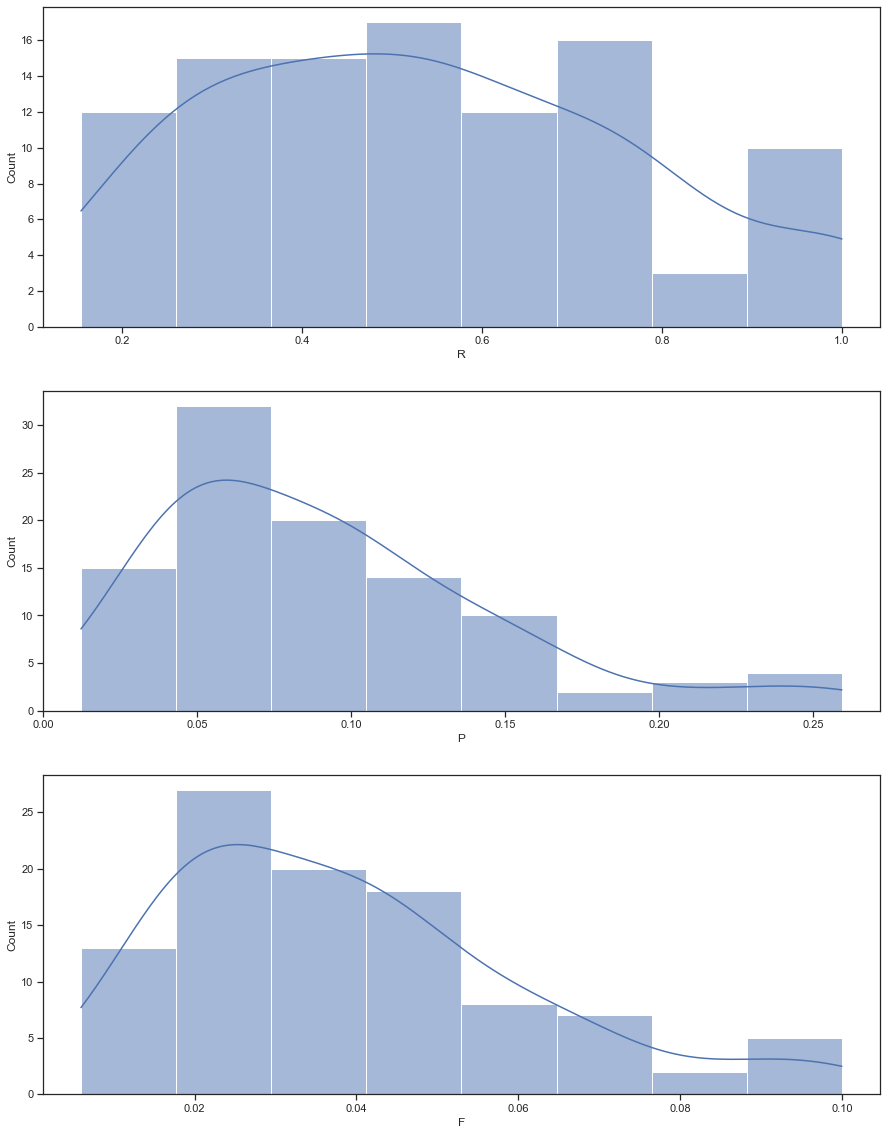

In [18]:
## Evaluation des performances la méthode de clustering pour l'extraction des alignements, $\lambda=0.002$ et $reg=0.0001$

def analyse_extraction(n_sentence):
    c = 0
    ids = []
    r_list = []
    p_list = []
    f_list = []
    for sentence_id in tqdm(range(n_sentence)):
        A = computeAlignments(
            sentence_id,0.6,0.002,
            regularization=True,
            epsilon_reg=0.0001,
            extractor=True,
            extraction_method=transform_DBS
        )
        r_list = r_list + [R(extract_al(A), extract_al(get_matrix(sentence_id)))]
        p_list = p_list + [P(extract_al(A), extract_al(get_matrix(sentence_id)))]
        f = F(extract_al(A), extract_al(get_matrix(sentence_id)))
        f_list = f_list + [f]
        ids = ids + [sentence_id]
    dict = {"sentence":ids,"R":r_list,"P":p_list,"F":f_list}
    df = pd.DataFrame(dict)
    sns.set_style('ticks')
    fig, ax = plt.subplots(3,1,figsize=(15,20))
    sns.histplot(data=df, x="R", kde=True, ax=ax[0])
    sns.histplot(data=df, x="P", kde=True, ax=ax[1])
    sns.histplot(data=df, x="F", kde=True, ax=ax[2])

analyse_extraction(100)

Les performances de cette méthode est finalement négligeable puisque comme le montre la figure, nous ne constatons aucune modification majeure des valeurs prises par $R$, $P$, et $F$.


La méthode DBScan est une méthode paramétrique très sensible, ce qui rend son évaluation difficile sans réelle étude approfondie. Ses paramètres sont $eps$, la distance maximale pour définir deux voisins, et $minSamples$, le nombre de voisins minimal pour constituer un cluster. Le choix de ces paramètres est crucial pour une solution de bonne qualité puisque la méthode y est très sensible. Nous avons décidé, après de nombreux essais, de prendre comme valeur :

\begin{align*}
eps&= \sigma(X)/4 \\
minSamples&=\max(2,\lfloor \frac{\lvert X \rvert}{2} \rfloor)
\end{align*}

puisqu'il est intuitif de prendre des valeurs basées sur la distribution des données. Le cardinal et l'écart-type sont deux grandeurs empiriques capables de fournir suffisamment d'information pour traduire la distribution des valeurs et donc optimiser le rôle de DBScan.


## Conclusion

En partant de nombreux articles récents sur la thématique du Word embedding, nous nous sommes orienté vers l'utilisation du Transport Optimal pour une application au problème du Word Alignment. Nous nous sommes donc intéressés à des outils d'optimisation de l'algorithme de Sinkhorn dans la résolution du Transport Optimal. 

Ensuite, nous avons cherché à optimiser la matrice de coût à différentes étapes de notre méthode initiale. La première étape a été la régularisation de la matrice de coût afin d'augmenter l'efficacité de l'algorithme de Sinkhorn. La seconde étape, quant à elle, a été de transformer les coûts de notre matrice afin d'aiguiller le système dans la bonne direction. Finalement, nous avons cherché à repenser la façon dont l'extraction des alignements finaux était faite en proposant une solution plus souple fondée sur une méthode de clustering. 

D'un point de vue global, nos expérimentations ont permis une amélioration légère mais visible des performances de l'algorithme de référence. De nombreuses pistes sont encore à explorer, notamment l'utilisation d'embeddings positionnels, une recherche d'optimisation des différents paramètre plus profonde et une étude sur un jeu de données plus grand.